<a href="https://colab.research.google.com/github/idc315/final-project/blob/main/Update_of_Final_Project_Project_2_Named_Entity_Recognition_(NER)_for_News_Articles_Group_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers datasets
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Load Dataset

In [4]:
from datasets import load_dataset
import pandas as pd
from transformers import pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")
train_data = dataset['train']
# Add model
pipe = pipeline("token-classification", model="dslim/bert-large-NER")
# Combine data into full sentences for processing
train_ds = [" ".join(example["tokens"]) for example in train_data]

print("Sample Training Sentence:", train_ds[0])
print("Sample Training data:", train_data[0])

Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sample Training Sentence: EU rejects German call to boycott British lamb .
Sample Training data: {'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


# Preprocessing

In [3]:
train_data_sample = pd.DataFrame(train_data[:1500])
train_data_sample


flat_data = []
for i in range(len(train_data_sample)):
    record = train_data_sample.iloc[i]
    tokens = record['tokens']
    ner_tags = record['ner_tags']
    sentence_id = record['id']

    for token, ner_tag in zip(tokens, ner_tags):
        flat_data.append({'Sentence_ID': sentence_id, 'Token': token, 'NER_Tag': ner_tag})

true_labels = pd.DataFrame(flat_data)

tag_mapping = {0 : '0', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC',6: 'I-LOC',7: 'B-MISC',8: 'I-MISC'}

true_labels ['True_Label'] = true_labels ['NER_Tag'].map(tag_mapping)
indexNames = true_labels [true_labels ['NER_Tag'] == 0 ].index
true_labels .drop(indexNames , inplace=True)
true_labels .drop(columns=['Sentence_ID','NER_Tag'], inplace=True)
true_labels .reset_index(drop=True, inplace=True)

true_labels_sample=true_labels
true_labels_sample
true_labels

,Token,True_Label
0,EU,B-ORG
1,German,B-MISC
2,British,B-MISC
3,Peter,B-PER
4,Blackburn,I-PER
...,...,...
3998,ADV,B-ORG
3999,Berlin,B-LOC
4000,Tegel,B-LOC
4001,Tempelhof,B-LOC


In [ ]:
train_sample = [" ".join(example["tokens"]) for example in train_data][:1500]
ner_results = [pipe(sentence) for sentence in train_sample]


def combine_subwords(ner_results):
    combined_results = []
    for sentence_results in ner_results:
        current_word = ""
        current_entity = None
        current_score = []
        current_start = None
        current_end = None

        for token in sentence_results:
            word = token["word"].replace("##", "")
            if current_word == "":
                current_word = word
                current_entity = token["entity"]
                current_score = [token["score"]]
                current_start = token["start"]
                current_end = token["end"]
            elif token["start"] == current_end:
                current_word += word
                current_score.append(token["score"])
                current_end = token["end"]
            else:
                combined_results.append({
                    "word": current_word,
                    "entity": current_entity,
                    "score": sum(current_score) / len(current_score),
                    "start": current_start,
                    "end": current_end,
                })

                current_word = word
                current_entity = token["entity"]
                current_score = [token["score"]]
                current_start = token["start"]
                current_end = token["end"]

        if current_word:
            combined_results.append({
                "word": current_word,
                "entity": current_entity,
                "score": sum(current_score) / len(current_score),
                "start": current_start,
                "end": current_end,
            })
    return combined_results

def ner_results_to_dataframe(ner_results):
    combined_results = combine_subwords(ner_results)
    df = pd.DataFrame(combined_results)
    return df

predict_labels_sample = ner_results_to_dataframe(ner_results)

predict_labels_sample

,word,entity,score,start,end
0,EU,B-ORG,0.999549,0,2
1,German,B-MISC,0.998968,11,17
2,British,B-MISC,0.999142,34,41
3,Peter,B-PER,0.999236,0,5
4,Blackburn,I-PER,0.998875,6,15
...,...,...,...,...,...
4113,ADV,B-ORG,0.998248,84,87
4114,Berlin,B-LOC,0.999117,0,6
4115,Tegel,B-LOC,0.980676,2,7
4116,Tempelhof,B-LOC,0.881133,2,11


# **Data distribution**

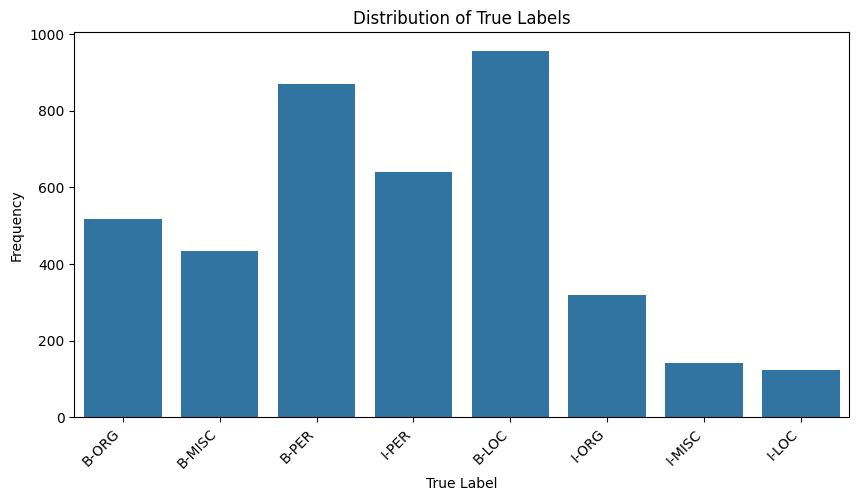

In [5]:
plt.figure(figsize=(10, 5))
sns.countplot(x="True_Label", data=pd.DataFrame(true_labels)) # Assuming 'true_labels' is your DataFrame
plt.xlabel("True Label")
plt.ylabel("Frequency")
plt.title("Distribution of True Labels")
plt.xticks(rotation=45, ha="right")
plt.show()

# NER Processing

In [ ]:
predicted_label_df = predict_labels_sample.rename(columns={"word": "Token", "entity": "Predicted_Label"}).drop(columns=["start", "end"])
true_label_df = true_labels_sample
print(true_label_df)
print(predicted_label_df)

            Token True_Label
0              EU      B-ORG
1          German     B-MISC
2         British     B-MISC
3           Peter      B-PER
4       Blackburn      I-PER
...           ...        ...
3998          ADV      B-ORG
3999       Berlin      B-LOC
4000        Tegel      B-LOC
4001    Tempelhof      B-LOC
4002  Schoenefeld      B-LOC

[4003 rows x 2 columns]
            Token Predicted_Label     score
0              EU           B-ORG  0.999549
1          German          B-MISC  0.998968
2         British          B-MISC  0.999142
3           Peter           B-PER  0.999236
4       Blackburn           I-PER  0.998875
...           ...             ...       ...
4113          ADV           B-ORG  0.998248
4114       Berlin           B-LOC  0.999117
4115        Tegel           B-LOC  0.980676
4116    Tempelhof           B-LOC  0.881133
4117  Schoenefeld           B-LOC  0.988938

[4118 rows x 3 columns]


In [ ]:
# Process to eliminate wrong tokens to balance the row between true and predicted data

mismatch_count = 0
new_true_label = []
new_predicted_label = []

i = 0
j = 0

while i < len(true_label_df) and j < len(predicted_label_df):
    true_token = true_label_df.loc[i, "Token"]
    predicted_token = predicted_label_df.loc[j, "Token"]

    if true_token == predicted_token:
        # Tokens match, append to new lists
        new_true_label.append(true_label_df.loc[i])
        new_predicted_label.append(predicted_label_df.loc[j])
        i += 1
        j += 1
    else:
        # Tokens don't match
        mismatch_count += 1
        match_found = False
        # Search for a match in the next 5 rows of predicted_label_df
        for k in range(1, 6):
            if j + k < len(predicted_label_df) and true_label_df.loc[i, "Token"] == predicted_label_df.loc[j + k, "Token"]:
                match_found = True
                j = j + k
                break

        if not match_found:
            i += 1
        else:
            new_true_label.append(true_label_df.loc[i])
            new_predicted_label.append(predicted_label_df.loc[j])
            i += 1
            j += 1


new_true_label_df = pd.DataFrame(new_true_label).reset_index(drop=True)
new_predicted_label_df = pd.DataFrame(new_predicted_label).reset_index(drop=True)

print("New True Label DataFrame:")
print(new_true_label_df)
print("\nNew Predicted Label DataFrame:")
print(new_predicted_label_df)
print(f"\nMismatch Count: {mismatch_count}")


New True Label DataFrame:
            Token True_Label
0              EU      B-ORG
1          German     B-MISC
2         British     B-MISC
3           Peter      B-PER
4       Blackburn      I-PER
...           ...        ...
3842          ADV      B-ORG
3843       Berlin      B-LOC
3844        Tegel      B-LOC
3845    Tempelhof      B-LOC
3846  Schoenefeld      B-LOC

[3847 rows x 2 columns]

New Predicted Label DataFrame:
            Token Predicted_Label     score
0              EU           B-ORG  0.999549
1          German          B-MISC  0.998968
2         British          B-MISC  0.999142
3           Peter           B-PER  0.999236
4       Blackburn           I-PER  0.998875
...           ...             ...       ...
3842          ADV           B-ORG  0.998248
3843       Berlin           B-LOC  0.999117
3844        Tegel           B-LOC  0.980676
3845    Tempelhof           B-LOC  0.881133
3846  Schoenefeld           B-LOC  0.988938

[3847 rows x 3 columns]

Mismatch Count:

# Evaluate the Model Performance

In [ ]:
comparison_df = pd.DataFrame({
    'True Label': new_true_label_df['True_Label'],
    'Predicted Label': new_predicted_label_df['Predicted_Label'],
    'Confidence Score': new_predicted_label_df['score'],
})
comparison_df

,True Label,Predicted Label,Confidence Score
0,B-ORG,B-ORG,0.999549
1,B-MISC,B-MISC,0.998968
2,B-MISC,B-MISC,0.999142
3,B-PER,B-PER,0.999236
4,I-PER,I-PER,0.998875
...,...,...,...
3842,B-ORG,B-ORG,0.998248
3843,B-LOC,B-LOC,0.999117
3844,B-LOC,B-LOC,0.980676
3845,B-LOC,B-LOC,0.881133


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
true_labels = new_true_label_df['True_Label']
predicted_labels = new_predicted_label_df['Predicted_Label']
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
f"Accuracy: {accuracy * 100:.2f}%"

'Accuracy: 99.58%'

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['B-PER','I-PER','B-ORG','I-ORG','B-LOC','I-LOC','B-MISC','I-MISC'])
conf_matrix

array([[850,   0,   1,   0,   1,   0,   0,   0],
       [  0, 633,   0,   1,   0,   0,   0,   0],
       [  1,   0, 493,   0,   1,   0,   0,   0],
       [  0,   0,   0, 310,   0,   0,   0,   0],
       [  0,   0,   2,   0, 909,   0,   0,   0],
       [  0,   0,   0,   1,   0, 121,   0,   0],
       [  2,   2,   0,   0,   2,   0, 384,   1],
       [  0,   1,   0,   0,   0,   0,   0, 131]])

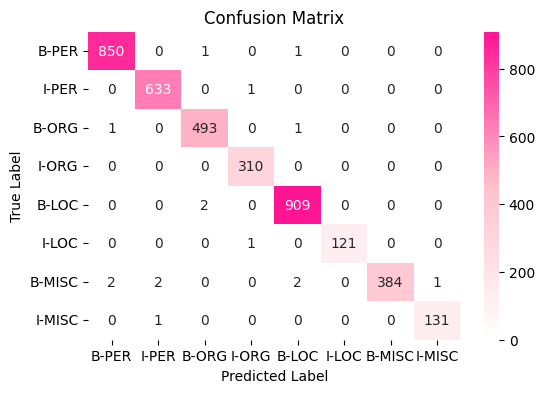

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
pink_cmap = LinearSegmentedColormap.from_list("custom_pink", ["white", "pink", "deeppink"])
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap= pink_cmap, xticklabels=['B-PER','I-PER','B-ORG','I-ORG','B-LOC','I-LOC','B-MISC','I-MISC'], yticklabels=['B-PER','I-PER','B-ORG','I-ORG','B-LOC','I-LOC','B-MISC','I-MISC'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Output

In [ ]:
# Take a smaller sample of the dataset
train_sentences = train_ds[0:100]
train_sentences

['EU rejects German call to boycott British lamb .',
 'Peter Blackburn',
 'BRUSSELS 1996-08-22',
 'The European Commission said on Thursday it disagreed with German advice to consumers to shun British lamb until scientists determine whether mad cow disease can be transmitted to sheep .',
 "Germany 's representative to the European Union 's veterinary committee Werner Zwingmann said on Wednesday consumers should buy sheepmeat from countries other than Britain until the scientific advice was clearer .",
 '" We do n\'t support any such recommendation because we do n\'t see any grounds for it , " the Commission \'s chief spokesman Nikolaus van der Pas told a news briefing .',
 'He said further scientific study was required and if it was found that action was needed it should be taken by the European Union .',
 'He said a proposal last month by EU Farm Commissioner Franz Fischler to ban sheep brains , spleens and spinal cords from the human and animal food chains was a highly specific and p

In [ ]:
# Print a few examples of NER results from the training sample
for i, result in enumerate(ner_results[0:8]):
    print(f"Sentence {i+1}:")
    print(train_sample[i])
    print("NER Results:", result)
    print("\n")


Sentence 1:
EU rejects German call to boycott British lamb .
NER Results: [{'entity': 'B-ORG', 'score': 0.99954885, 'index': 1, 'word': 'EU', 'start': 0, 'end': 2}, {'entity': 'B-MISC', 'score': 0.99896777, 'index': 3, 'word': 'German', 'start': 11, 'end': 17}, {'entity': 'B-MISC', 'score': 0.99914205, 'index': 7, 'word': 'British', 'start': 34, 'end': 41}]


Sentence 2:
Peter Blackburn
NER Results: [{'entity': 'B-PER', 'score': 0.99923646, 'index': 1, 'word': 'Peter', 'start': 0, 'end': 5}, {'entity': 'I-PER', 'score': 0.99887496, 'index': 2, 'word': 'Blackburn', 'start': 6, 'end': 15}]


Sentence 3:
BRUSSELS 1996-08-22
NER Results: [{'entity': 'B-LOC', 'score': 0.99911183, 'index': 1, 'word': 'BR', 'start': 0, 'end': 2}, {'entity': 'I-LOC', 'score': 0.98171645, 'index': 2, 'word': '##US', 'start': 2, 'end': 4}, {'entity': 'I-LOC', 'score': 0.9843754, 'index': 3, 'word': '##SE', 'start': 4, 'end': 6}, {'entity': 'I-LOC', 'score': 0.99076605, 'index': 4, 'word': '##LS', 'start': 6, 'en

In [ ]:
# Function to combine multi-token entities into a single annotation
def combine_ner_entities(sentence, ner_results):
    combined_entities = []
    current_entity = None
    current_start = None
    current_end = None

    for entity in ner_results:
        token = sentence[entity["start"]:entity["end"]]
        entity_type = entity["entity"]

        if entity_type.startswith("B-"):  # Start a new entity
            if current_entity:  # Save the previous entity
                combined_entities.append(
                    (sentence[current_start:current_end], current_entity, current_start, current_end)
                )
            current_entity = entity_type[2:]  # Strip "B-" to get entity type
            current_start = entity["start"]
            current_end = entity["end"]
        elif entity_type.startswith("I-") and current_entity:  # Continue the same entity
            current_end = entity["end"]
        else:  # Non-entity or unrelated token
            if current_entity:  # Save the previous entity
                combined_entities.append(
                    (sentence[current_start:current_end], current_entity, current_start, current_end)
                )
            current_entity = None

    # Save the last entity if it exists
    if current_entity:
        combined_entities.append(
            (sentence[current_start:current_end], current_entity, current_start, current_end)
        )

    return combined_entities

# Function to format a sentence with identified entities
def format_combined_ner(sentence, combined_entities):
    # Replace entities in the sentence, starting with the last to avoid index conflicts
    formatted_sentence = sentence
    for token, entity_type, start, end in sorted(
        combined_entities, key=lambda x: x[2], reverse=True
    ):
        formatted_sentence = (
            formatted_sentence[:start]
            + f"{token}({entity_type})"
            + formatted_sentence[end:]
        )
    return formatted_sentence

# Process a small sample of the training data
for i, sentence in enumerate(train_sample[5:15]):  # Process first 5 sentences
    ner_results = pipe(sentence)  # Perform NER
    combined_entities = combine_ner_entities(sentence, ner_results)  # Merge tokens/entities
    formatted_sentence = format_combined_ner(sentence, combined_entities)  # Annotate sentence

    # Print the results
    print(f"Original: {sentence}")
    print(f"Formatted: {formatted_sentence}")
    print("\n")


Original: " We do n't support any such recommendation because we do n't see any grounds for it , " the Commission 's chief spokesman Nikolaus van der Pas told a news briefing .
Formatted: " We do n't support any such recommendation because we do n't see any grounds for it , " the Commission(ORG) 's chief spokesman Nikolaus van der Pas(PER) told a news briefing .


Original: He said further scientific study was required and if it was found that action was needed it should be taken by the European Union .
Formatted: He said further scientific study was required and if it was found that action was needed it should be taken by the European Union(ORG) .


Original: He said a proposal last month by EU Farm Commissioner Franz Fischler to ban sheep brains , spleens and spinal cords from the human and animal food chains was a highly specific and precautionary move to protect human health .
Formatted: He said a proposal last month by EU(ORG) Farm Commissioner Franz Fischler(PER) to ban sheep bra